# TC Intensity Classification using Random data split
In this notebook we proceed to perform the same experiments as in [Classification_Model](Classification_Model.ipynb) but with a different data split. That is, we proceed to use completely randomised datasets. That is, the training, validation and test datasets have been generated at image level. Meaning that images from same sequences may be found in different sets. 

Note that this clearly may influence the evaluation process, as now test data contains images from typhoon sequences which have been partially (some images) used to traing the model.

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../..')

We will use GPU with identifier "1", after agreeing with other users with access to the same machine. If you are not using GPU or don't have any restriction on GPU usage skip this step.

In [5]:
from os import environ

environ["CUDA_VISIBLE_DEVICES"]="1"

## 1. Load data
Time to load the data. The data is stored in chunk HDF5 files, which have been previously been generated using script [generate_dataset.py](../../../scripts/generate_dataset.py). We will use chunks 0-26 for training, 27-24 for validation and 35-47 for testing. Note that loading the chunks might take a while. Grab yourself a tee.

In [6]:
from os import listdir

# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/random_256/'
chunk_filenames = listdir(dataset_dir)
train_chunk_filenames = chunk_filenames[:27]
valid_chunk_filenames = chunk_filenames[27:35]
test_chunk_filenames = chunk_filenames[35:]

For this task, we will ignore classes 6 and 7 and only focus on Tropical Cyclones.

In [7]:
from pyphoon.app.utils import load_h5datachunks

X_train, Y_train, idx_train, seqno_train = load_h5datachunks(dataset_dir,
                                                             train_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                             )

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                            )

X_test, Y_test, idx_test, seqno_test = load_h5datachunks(dataset_dir, 
                                                         test_chunk_filenames, 
                                                         features=['data', 'class', 'idx', 'seq_no'],
                                                         ignore_classes=[6, 7],
                                                         verbose=True
                                                         )

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


 file 0_chunk.h5 read
 file 1_chunk.h5 read
 file 2_chunk.h5 read
 file 3_chunk.h5 read
 file 4_chunk.h5 read
 file 5_chunk.h5 read
 file 6_chunk.h5 read
 file 7_chunk.h5 read
 file 8_chunk.h5 read
 file 9_chunk.h5 read
 file 10_chunk.h5 read
 file 11_chunk.h5 read
 file 12_chunk.h5 read
 file 13_chunk.h5 read
 file 14_chunk.h5 read
 file 15_chunk.h5 read
 file 16_chunk.h5 read
 file 17_chunk.h5 read
 file 18_chunk.h5 read
 file 19_chunk.h5 read
 file 20_chunk.h5 read
 file 21_chunk.h5 read
 file 22_chunk.h5 read
 file 23_chunk.h5 read
 file 24_chunk.h5 read
 file 25_chunk.h5 read
 file 26_chunk.h5 read
 file 27_chunk.h5 read
 file 28_chunk.h5 read
 file 29_chunk.h5 read
 file 30_chunk.h5 read
 file 31_chunk.h5 read
 file 32_chunk.h5 read
 file 33_chunk.h5 read
 file 34_chunk.h5 read
 file 35_chunk.h5 read
 file 36_chunk.h5 read
 file 37_chunk.h5 read
 file 38_chunk.h5 read
 file 39_chunk.h5 read
 file 40_chunk.h5 read
 file 41_chunk.h5 read
 file 42_chunk.h5 read
 file 43_chunk.h5 rea

### 1.1 Balance dataset
The distribution of the classes is not balanced. Hence, we proceed to balance it which gives our model equal chances to perform good on all classes.

In [8]:
from pyphoon.app.utils import balance_dataset

# test
print("test...")
for i in range(len(Y_test)):
    # Get labels and valid positions
    pos = balance_dataset(Y_test[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_test[i] = X_test[i][pos]
    Y_test[i] = Y_test[i][pos]
    idx_test[i] = idx_test[i][pos]
    seqno_test[i] = seqno_test[i][pos]

# valid
print("valid...")
for i in range(len(Y_valid)):
    # Get labels and valid positions
    pos = balance_dataset(Y_valid[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_valid[i] = X_valid[i][pos]
    Y_valid[i] = Y_valid[i][pos]
    idx_valid[i] = idx_valid[i][pos]
    seqno_valid[i] = seqno_valid[i][pos]
    
# train
print("train...")
for i in range(len(Y_train)):
    # Get labels and valid positions
    pos = balance_dataset(Y_train[i], [2,3,4,5])
    # Retrieve corresponding samples
    X_train[i] = X_train[i][pos]
    Y_train[i] = Y_train[i][pos]
    idx_train[i] = idx_train[i][pos]
    seqno_train[i] = seqno_train[i][pos]

test...
valid...
train...


Let us plot the histograms of the sets to verify that the data is equally balanced now.

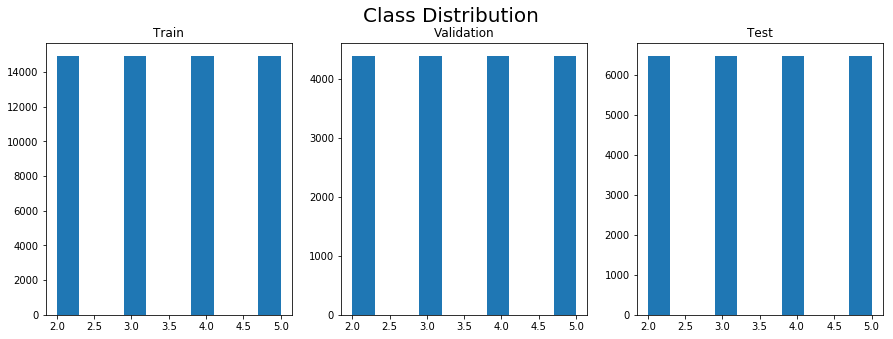

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,5))
y_train = np.concatenate(Y_train)
y_valid = np.concatenate(Y_valid)
y_test = np.concatenate(Y_test)

plt.subplot(1,3,1)
plt.hist(y_train)
plt.title("Train")
plt.subplot(1,3,2)
plt.hist(y_valid)
plt.title("Validation")
plt.subplot(1,3,3)
plt.hist(y_test)
plt.title("Test")
plt.suptitle("Class Distribution", fontsize=20)
plt.show()

## 2. Data Preprocessing

### 2.1 Data overview
First of all, let us gain some knowledge of our data by printing the amount of samples in training, validation and test sets.

In [11]:
# Number of samples in dataset
n1 = sum([len(x) for x in X_train])
n2 = sum([len(x) for x in X_valid])
n3 = sum([len(x) for x in X_test])
print("train:", n1)
print("valid:", n2)
print("test:", n3)
print("total:", n1+n2+n3)

train: 59708
valid: 17536
test: 25904
total: 103148


### 2.2. Load preprocessing parameters
In this experiment, as already highlighted we will be using a different dataset set up. Thus, we will also use different preprocessing parameters. You may find those at `'../preprocessing_random.h5'`. 

As before, following parameters are found in this file:

- Mean image: Image containing the mean for each pixel location.
- Pixel mean: Overal pixel intensity mean (scalar value).
- Pixel standard deviation: Overall pixel standard deviation (scalar value).
- Pixel maximum value: Overall maximum pixel intensity value (scalar value).
- Pixel minimum value: Overall minimum pixel intensity value (scalar value).

Depending on your needs, you may use `MeanImagePreprocessor` or`DefaultImagePreprocessor` to preprocess your data. Generation of these files is easy, and is done by `pyphoon.app.preprocess.generate_preprocess_params`. Set variable `generate_params` below to True to do so, however, the repository already provides precomputed preprocessing parameters.

In [12]:
generate_params = False
if generate_params:
    from pyphoon.app.preprocess import generate_preprocess_params
    generate_preprocess_params(X_train, "../preprocessing_random.h5")

For this task, we will use `MeanImagePreprocessor`, which uses the dataset mean image to centre the data and the minimum and maximum pixel values to normalise the images. To this end, we have previously computed these parameters and stored them under file `random.h5`. Note that the next step may take a while...

In [14]:
import h5py

# Define preprocessor
with h5py.File('../preprocessing_random.h5') as f:
    mean = f.get('image_mean').value
    scale_factor = f.get('max_value').value - f.get('min_value').value

### 2.3. Preprocessor
We define the preprocessing pipeline here. However, the preprocessing of the data is done in the data generator when training the model. This way, we reduce the memory requirements.

In [15]:
from pyphoon.app.preprocess import MeanImagePreprocessor

# Define preprocessor
preprocessor = MeanImagePreprocessor(mean, scale_factor, add_axis=[3])

## 3. Model
We use the same architecture and hyper-parameters than in the [Classification_Model](Classification_Model.ipynb) notebook. You may refer to section 3.3 to load pretrained weights instead of training. However, make sure to define the model architecture first.

In [16]:
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, \
    Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

### 3.1 Model Architecture

In [19]:
input_img = Input(shape=(128, 128, 1), name="in")
############################################################################
# Convolutional Layers
############################################################################
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv2d_1')(
    input_img)
x = Activation('relu', name='activation_1')(x)
x = BatchNormalization(name="batch_normalization_1")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_1')(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv2d_2')(x)
x = Activation('relu', name='activation_2')(x)
x = BatchNormalization(name="batch_normalization_2")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_2')(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv2d_3')(x)
x = Activation('relu', name='activation_3')(x)
x = BatchNormalization(name="batch_normalization_3")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_3')(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv2d_4')(x)
x = Activation('relu', name='activation_4')(x)
x = BatchNormalization(name="batch_normalization_4")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='max_pooling2d_4')(x)
############################################################################
# Dense Layers
############################################################################
x = Flatten()(x)

x = Dense(512, use_bias=True, name="dense_1")(x)
x = Activation('relu', name="activation_5")(x)
x = BatchNormalization(name="batch_normalization_5")(x)
x = Dropout(0.2, name="dropout_1")(x)

x = Dense(256, use_bias=True, name="dense_2")(x)
x = Activation('relu', name="activation_6")(x)
x = BatchNormalization(name="fc_bn2")(x)

############################################################################
# Output
############################################################################
x = Dense(4, use_bias=True, name="dense_3")(x)
x = Activation('softmax', name="out")(x)

############################################################################
# Modelshinjuku to asa
############################################################################
model = Model(input_img, x)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy'])

### 3.2 Callbacks
Before training, we will define some usefull callbacks to supervise the training process. One of the most usefull callbacks is [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which enables easy visualisation of loss and accuracy curves.

Make sure to use the following command to run the tensorboard client.

```
$ tensorboard --logdir=<path/to/log-directory> --port <port>
```

Once the model is training you may check its performance by navigating to `localhost:<port>`.

In [21]:
from pyphoon.app.callbacks import StoreModelWeights, OurTensorBoard, LossHistory

foldername = 'results_random_2'
storeweights_callback = StoreModelWeights(foldername, naming="val_acc")
tensorboard_callback = OurTensorBoard(foldername)
loss_callback = LossHistory()

callbacks = [loss_callback, storeweights_callback, tensorboard_callback]

### 3.3 Training
Finally, To feed our model with input data we will use a data generator, provided by method `data_generator_from_chunklist` from `pyphoon.app.utils`.

In [ ]:
from pyphoon.app.utils import DataGeneratorFromChunklist

# Generator
batch_size = 32
generator = DataGeneratorFromChunklist(batch_sz=batch_size,
                                       preprocess_algorithm=preprocessor.apply,
                                       target_enc='ohe',
                                       crop=128
                                       )

# Number steps
n_steps_train = sum([np.ceil(len(x)/batch_size) for x in Y_train])
n_steps_valid = sum([np.ceil(len(x)/batch_size) for x in Y_valid])

# Number of full epochs, i.e. #times algorithm sees all the data
epochs = 10

# Train
model.fit_generator(
    generator=generator.feed(X_train, Y_train),
    steps_per_epoch=n_steps_train,
    validation_data=generator.feed(X_valid, Y_valid),
    validation_steps=n_steps_valid,
    epochs=epochs,
    callbacks=callbacks
)

### 3.4 Load pre-trained weights
Here we load the weights that provided the best performance and evaluate the performance on the test data. l.

In [25]:
model.load_weights('../weights_random.hdf5')

## 4. Results
### 4.1 Test accuracy
We evaluate the model that performed best on the validation set on the test set. This is the final performance of our model.

In [26]:
# Generator
batch_size = 32
generator = DataGeneratorFromChunklist(batch_sz=batch_size, 
                                       preprocess_algorithm=preprocessor.apply, 
                                       target_enc='ohe',
                                       crop=128)
# Number steps
n_steps = sum([np.ceil(len(x)/batch_size) for x in Y_test])

# Get predictions
y_pred = model.predict_generator(
    generator=generator.feed(X_test, Y_test, shuffle_batches=False, shuffle_samples=False),
    steps=n_steps
)
y_pred = np.argmax(y_pred, axis=1)

# Ground truth
y_true = (np.concatenate(Y_test) - 2).tolist()

# Test accuracy
acc_test = (np.array(y_true) == np.array(y_pred)).mean()
print("Accuracy on test set:", acc_test)

Accuracy on test set: 0.828211859172


### 4.2 Confusion Matrix, precision, recall
Now we take a closer look in an attempt to see if our model is biased towards some category.

In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(y_true, y_pred), 
             columns=['predicted 2','predicted 3','predicted 4','predicted 5'], 
             index=['2', '3', '4', '5']
            )

,predicted 2,predicted 3,predicted 4,predicted 5
2,5586,769,105,16
3,809,4893,660,114
4,147,646,5169,514
5,26,131,513,5806


In [28]:
from sklearn.metrics import classification_report

# Get complete report
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.86      0.86      6476
          1       0.76      0.76      0.76      6476
          2       0.80      0.80      0.80      6476
          3       0.90      0.90      0.90      6476

avg / total       0.83      0.83      0.83     25904



## 5. Conclusions
From this short experiment, we can conclude that the way the data is distributed among all datasets (training, validation and test) has a big impact on the final evaluated performance of the model.

Performance using random split is high, as expected. This might be due to several reasons:
- Images from different sequences might be subject to some measurement biases due to variations in the state of the sensors throughout the years. Also, depending on the period, different satellites were being used.
- Images one hour apart from the same sequence are practically identical. Therefore, practically speaking the model is evaluated on data that it has almost "already seen" during training.

We argue that random split is not a realistic set up. Reasons:
- In general, we want to make our predictions using data from the past. That is, from other sequences that we registered and analysed before.
- When analysing data from a new sequence, predictions from it are usually not available or might be subject to some errors.